In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib,pprint,keras
import random

import FBNN2d,sei_kume,myResNet
importlib.reload(FBNN2d)
importlib.reload(sei_kume)
importlib.reload(myResNet)
from FBNN2d import *
from sei_kume import *
from myResNet import *

# データが少ない場合の予測精度

In [22]:
# multi=100
def td_gen(multi,gene_size=20,rep=10):
    td1 = [gene_data(hist_gene,Sig_lim=20,mu_lim=20,gene_size=gene_size,multi=multi) for _ in range(rep)]
    td2 = [gene_data_zero(hist_gene,Sig_lim=20,mu_lim=20,gene_size=gene_size,multi=multi,center=None) for _ in range(rep)]
    td7 = [gene_data_zero(hist_gene,Sig_lim=20,mu_lim=20,gene_size=gene_size,multi=multi,center=None) for _ in range(rep)]
    return {"1":td1,"2":td2,"7":td7}

In [20]:
gene_size=500
print_size=int(gene_size/2)

for multi in [1e6,1e3,1e2,1e1]:
    (x_test,Sigmus) = gene_data(hist_gene,Sig_lim=20,mu_lim=20,gene_size=gene_size,multi=multi)
    tds=td_gen(multi)
    print(multi,":")
    for num in [1,2,7]:
        model = keras.models.load_model("./models/mymodel_0start%d.h5"%num, compile=False)
        model.compile(loss='mse',optimizer='adam',metrics=['mae'])
        y_preds = model.predict(x_test, verbose=0)

        # mse,maeも確認してみる
        scores=[model.evaluate(x_test, y_test, verbose=0) for (x_test, y_test) in tds["%d"%num]]
        score = np.mean(scores,axis=0)
        # print("%d:Test loss, Test mae: %f, %f" % (num,score[0], score[1]))

        res=[]
        for i,y_pred in enumerate(y_preds):
            if(num<=2 or num==7):
                Sig0 = [y_pred[0:2],y_pred[1:3]]
                mu0 = y_pred[3:5]
                # print(np.linalg.eig(Sig0)[1].T)
                O0 = np.linalg.eig(Sig0)[1].T
                O0 = np.diag(np.sign(O0@Sig0@mu0)+1e-2)@O0
                th0 = np.diag(O0@Sig0@O0.T)/2
                ga0 = O0@Sig0@mu0

            Sig_T=[Sigmus[i][0:2],Sigmus[i][1:3]]
            mu_T=Sigmus[i][3:5]
            O_T = np.linalg.eig(Sig_T)[1].T
            O_T = np.diag(np.sign(O_T@Sig_T@mu_T))@O_T
            th_T = np.diag(O_T@Sig_T@O_T.T)/2
            ga_T = O_T@Sig_T@mu_T

            hist = x_test[i]
            A,B,n = AB_gene(hist)

            log_0 = Loglikelihood(th0,ga0,A,B,O=O0,n=1,method="hg")
            log_T = Loglikelihood(th_T,ga_T,A,B,O=O_T,n=1,method="hg")
            # print("%2d:log_T, log_0: %f, %f"%(i+1,log_T["log"],log_0["log"]))
            res.append(abs(log_T["log"]-log_0["log"]))
            # if(i%print_size==0): print(res[-1])
        # print("%d:mean diff:"%num, np.mean(res))
        print("%d:mean diff:%f ;Test loss, Test mae: %f, %f" % (num, np.mean(res), score[0], score[1]))
    print()

1000000.0 :
1:mean diff:1.977624 ;Test loss, Test mae: 19.032858, 3.413535
2:mean diff:1.243580 ;Test loss, Test mae: 38.053729, 4.150086
7:mean diff:1.605748 ;Test loss, Test mae: 40.244080, 4.140087

1000.0 :
1:mean diff:1.970450 ;Test loss, Test mae: 20.298381, 3.539922
2:mean diff:1.226315 ;Test loss, Test mae: 39.087468, 4.206553
7:mean diff:1.860482 ;Test loss, Test mae: 50.548190, 4.620006

100.0 :
1:mean diff:1.971569 ;Test loss, Test mae: 20.950784, 3.572481
2:mean diff:1.232996 ;Test loss, Test mae: 37.364967, 4.080330
7:mean diff:1.749581 ;Test loss, Test mae: 42.868247, 4.254750

10.0 :
1:mean diff:2.018408 ;Test loss, Test mae: 20.713976, 3.526667
2:mean diff:1.363441 ;Test loss, Test mae: 38.315066, 4.219808
7:mean diff:1.609734 ;Test loss, Test mae: 42.960965, 4.216785



# ノイズありデータにおける予測精度

In [23]:
gene_size=500
print_size=int(gene_size/2)

for multi in [1e6,1e3,1e2,1e1]:
    (x_test,Sigmus) = gene_data(hist_gene_noise,Sig_lim=20,mu_lim=20,gene_size=gene_size,multi=multi)
    tds=td_gen(multi)
    print(multi,":")
    for num in [1,2,7]:
        model = keras.models.load_model("./models/mymodel_0start%d.h5"%num, compile=False)
        model.compile(loss='mse',optimizer='adam',metrics=['mae'])
        y_preds = model.predict(x_test, verbose=0)

        # mse,maeも確認してみる
        scores=[model.evaluate(x_test, y_test, verbose=0) for (x_test, y_test) in tds["%d"%num]]
        score = np.mean(scores,axis=0)
        # print("%d:Test loss, Test mae: %f, %f" % (num,score[0], score[1]))

        res=[]
        for i,y_pred in enumerate(y_preds):
            if(num<=2 or num==7):
                Sig0 = [y_pred[0:2],y_pred[1:3]]
                mu0 = y_pred[3:5]
                # print(np.linalg.eig(Sig0)[1].T)
                O0 = np.linalg.eig(Sig0)[1].T
                O0 = np.diag(np.sign(O0@Sig0@mu0)+1e-2)@O0
                th0 = np.diag(O0@Sig0@O0.T)/2
                ga0 = O0@Sig0@mu0

            Sig_T=[Sigmus[i][0:2],Sigmus[i][1:3]]
            mu_T=Sigmus[i][3:5]
            O_T = np.linalg.eig(Sig_T)[1].T
            O_T = np.diag(np.sign(O_T@Sig_T@mu_T))@O_T
            th_T = np.diag(O_T@Sig_T@O_T.T)/2
            ga_T = O_T@Sig_T@mu_T

            hist = x_test[i]
            A,B,n = AB_gene(hist)

            log_0 = Loglikelihood(th0,ga0,A,B,O=O0,n=1,method="hg")
            log_T = Loglikelihood(th_T,ga_T,A,B,O=O_T,n=1,method="hg")
            # print("%2d:log_T, log_0: %f, %f"%(i+1,log_T["log"],log_0["log"]))
            res.append(abs(log_T["log"]-log_0["log"]))
            # if(i%print_size==0): print(res[-1])
        # print("%d:mean diff:"%num, np.mean(res))
        print("%d:mean diff:%f ;Test loss, Test mae: %f, %f" % (num, np.mean(res), score[0], score[1]))
    print()

1000000.0 :
1:mean diff:1.997377 ;Test loss, Test mae: 20.556960, 3.546714
2:mean diff:1.250779 ;Test loss, Test mae: 43.163287, 4.285350
7:mean diff:1.709789 ;Test loss, Test mae: 41.776596, 4.170349

1000.0 :
1:mean diff:1.956475 ;Test loss, Test mae: 20.604956, 3.571189
2:mean diff:1.420339 ;Test loss, Test mae: 37.688714, 4.051659
7:mean diff:2.044185 ;Test loss, Test mae: 39.560715, 4.140327

100.0 :
1:mean diff:4.793766 ;Test loss, Test mae: 18.685921, 3.402278
2:mean diff:5.240037 ;Test loss, Test mae: 39.758058, 4.220193
7:mean diff:5.106152 ;Test loss, Test mae: 45.293312, 4.432834

10.0 :
1:mean diff:53.521501 ;Test loss, Test mae: 21.598526, 3.562600
2:mean diff:51.199600 ;Test loss, Test mae: 38.711808, 4.230580
7:mean diff:44.099887 ;Test loss, Test mae: 44.574506, 4.359166



### 学習時からノイズを混ぜる

noise+LReLU
1000:mean diff:1.475166 ;Test loss, Test mae: 33.418401, 3.488010
100:mean diff:3.320806 ;Test loss, Test mae: 34.173045, 3.553953
 10:mean diff:27.898245 ;Test loss, Test mae: 50.104672, 4.681037
noise+ReLU+Resnet


/home/user/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1000:mean diff:1.548478 ;Test loss, Test mae: 33.479061, 3.465138
100:mean diff:4.411475 ;Test loss, Test mae: 37.540167, 3.757531
 10:mean diff:45.864405 ;Test loss, Test mae: 90.019907, 7.042224


/home/user/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


noise+LReLU+Resnet
1000:mean diff:3.018412 ;Test loss, Test mae: 35.335198, 3.554582
100:mean diff:5.854616 ;Test loss, Test mae: 37.588289, 3.733643
 10:mean diff:55.187115 ;Test loss, Test mae: 101.665092, 7.365968


/home/user/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


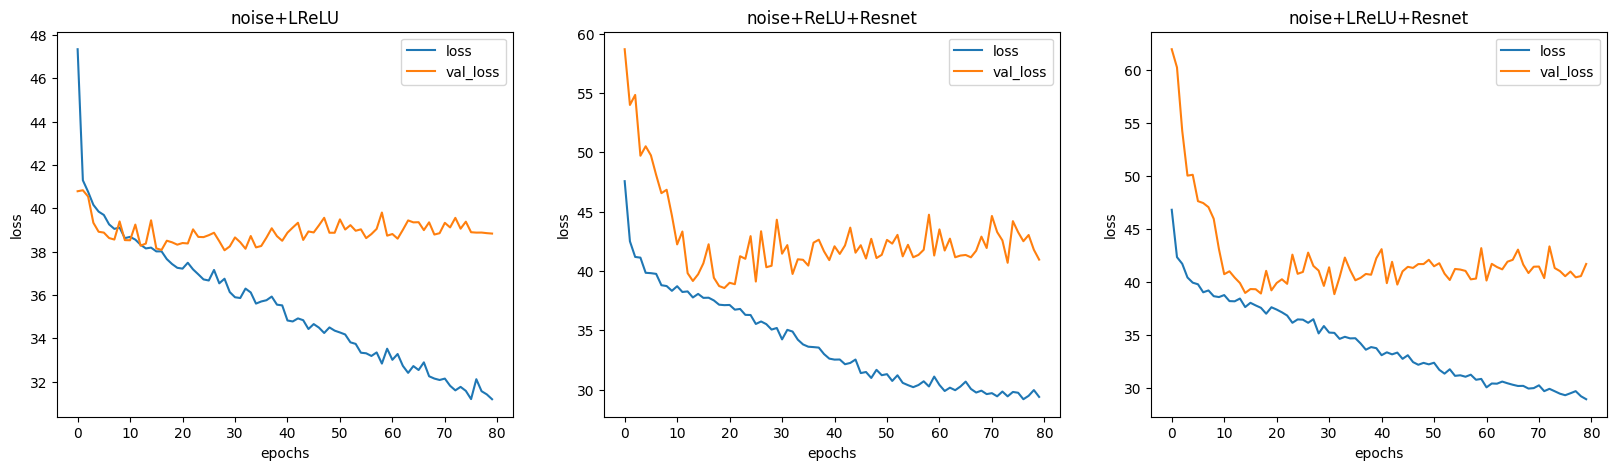

In [38]:
# gd_f = gene_data_zero_thga3
# hg_f = hist_gene_thga
# hg_noise_f = hist_gene_thga_noise

gd_f = gene_data_zero
hg_f = hist_gene
hg_noise_f = hist_gene_noise

(x_train0,y_train0) = gd_f(hg_f,Sig_lim=20,mu_lim=20,gene_size=2000,multi=-1) #1e6
(x_train1,y_train1) = gd_f(hg_noise_f,Sig_lim=20,mu_lim=20,gene_size=200,multi=-1)
(x_train2,y_train2) = gd_f(hg_noise_f,Sig_lim=20,mu_lim=20,gene_size=20,multi=-1)
# print(type(x_train))
x_train=list(x_train1)+list(x_train0)+list(x_train2)
y_train=list(y_train1)+list(y_train0)+list(y_train2)

mul=[1e3,1e2,1e1]
tds = [[gd_f(hg_noise_f,Sig_lim=20,mu_lim=20,gene_size=20,multi=multi) for _ in range(10)] for multi in mul]

models=[]
models.append(set_model_zero_LeakyReLU(output_shape=5,n_hidden=400,n_layer=5,print_summary=False,leaky_alpha=0.01))
models.append(build((20,), 5, 400,hidden_layer=18))
models.append(build((20,), 5, 400,hidden_layer=18,leakyReLU=True,leaky_alpha=0.01))

titles=["noise+LReLU","noise+ReLU+Resnet","noise+LReLU+Resnet"]
fig, axes = plt.subplots(ncols=len(models), figsize=(20, 5))
for i,model in enumerate(models):
    print(titles[i])
    model.compile(loss='mse',
                    optimizer='adam',
                    # optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
                    metrics=['mae'])

    history = model.fit(np.array(x_train), np.array(y_train), verbose=0,
                        epochs=80, validation_split=0.2, shuffle=True
                        # epochs=80, batch_size=30,validation_data=(x_test, y_test)
                        )

    for j,test_data in enumerate(tds):
        scores=[model.evaluate(x_test, y_test, verbose=0) for (x_test, y_test) in test_data]
        score = np.mean(scores,axis=0)

        res_mean = np.mean([comp_logL_Sigmu(model,x_test,y_test)[0] for (x_test, y_test) in test_data])
        # print("Test loss, Test mae: %f, %f" % (score[0], score[1]))
        print("%4d:mean diff:%f ;Test loss, Test mae: %f, %f" % (mul[j], res_mean, score[0], score[1]))
    model.save("./models/mymodel_0start%d.h5"%(i+8), include_optimizer=False)
    print()

    df = pd.DataFrame(history.history)[['loss', 'val_loss']]
    df.plot(ax=axes[i],xlabel="epochs",ylabel="loss",title=titles[i])
plt.show()